In [1]:
%load_ext autoreload
%autoreload 2

#%load_ext memory_profiler
#%load_ext line_profiler

In [26]:
#use case example
#%lprun -f range range(100000)
#%mprun >>

# with Timer() as t:
#     range(1000)
# print("elasped lpush: %s s" % t.secs)

elasped lpush: 2.90870666504e-05 s


In [3]:
from __future__ import print_function
import IPython
import pickle
#
import os, sys, math
import pandas as pd
import time
import numpy as np
#import pandas as pd
import sklearn as skl
import statistics
from sklearn.neighbors import NearestNeighbors, DistanceMetric
#from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import scipy.special as sp
#
import eknn
from wrap import *

#pretty plots if seaborn is installed
try: 
    import seaborn as sns
    sns.set(style='ticks', palette='Set2',font_scale=1.5)
    #sns.set() 
except:
    pass

%matplotlib inline

/Users/yabebal/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## PyStan example

In [4]:
import pystan

# First we will write our Baysian model using
# Stan code. 
# We will then define our data and call pystan 
# to do MCMC sampling using NUT sampler
# 
mvgauss_code="""
data {
  int<lower=1> N;
  vector[N] v;
  vector[N] y;
}
parameters {
  vector[N] mu; 
}
transformed parameters {  
  cov_matrix[N] Sigma;
  for (i in 1:N) 
    for (j in 1:N)
      Sigma[i,j] <- 0 + if_else(i==j, v[i], 0.0);
}
model {
  increment_log_prob(multi_normal_log(y,mu,Sigma));
  // y ~ multi_normal(mu,Sigma); //drops constants
}
"""

# Define data model: we will use 10-dimensional Gaussian
# as given in the alan_eg
dmv=eknn.alan_eg()
mvgauss_dat={'y':dmv.mean_sample,
             'v':dmv.sigma_mean**2,
             'N':dmv.ndim}

#file name where to save/read chain
cache_falan='chains/alan_pystan_chain.pkl'

#read chain from cache if possible 
try:
    #raise
    print('reading chain from: '+cache_falan)
    alan_stan_chain = pickle.load(open(cache_falan, 'rb'))
except:
    # Get pystan chain-- this will convert our pystan code into C++
    # and run MCMC
    if alan_fit in locals():
        #faster as we don't need C++ compiling
        alan_fit = pystan.stan(fit=alan_fit, data=mvgauss_dat, 
                               iter=100000, chains=4)     
    else:
        alan_fit = pystan.stan(model_code=mvgauss_code, data=mvgauss_dat,
                      iter=100000, chains=4)    
    

    # Extract PyStan chain for Harry's GLM example
    alan_stan_chain=alan_fit.extract(permuted=True)   
    print('writing chain in: '+cache_falan)
    with open(cache_falan, 'wb') as f:
            pickle.dump(alan_stan_chain, f)
            
if 'mu' in alan_stan_chain.keys(): alan_stan_chain['samples']=alan_stan_chain.pop('mu')
if 'lp__' in alan_stan_chain.keys(): alan_stan_chain['lnprob']=alan_stan_chain.pop('lp__')
    
print('chain shape: ',alan_stan_chain['samples'].shape)


mean_sample= [  0.9971811    2.00366069   3.00116907   3.99936755   4.99779517
   6.00342014   7.00228918   7.99790534   9.00003443  10.00313422]
std_sample= [ 0.99820698  1.00560363  0.99959052  1.00125741  1.00229146  0.99603665
  0.99708642  1.00295617  0.99912791  1.00159745]

reading chain from: chains/alan_pystan_chain.pkl
chain shape:  (200000, 10)


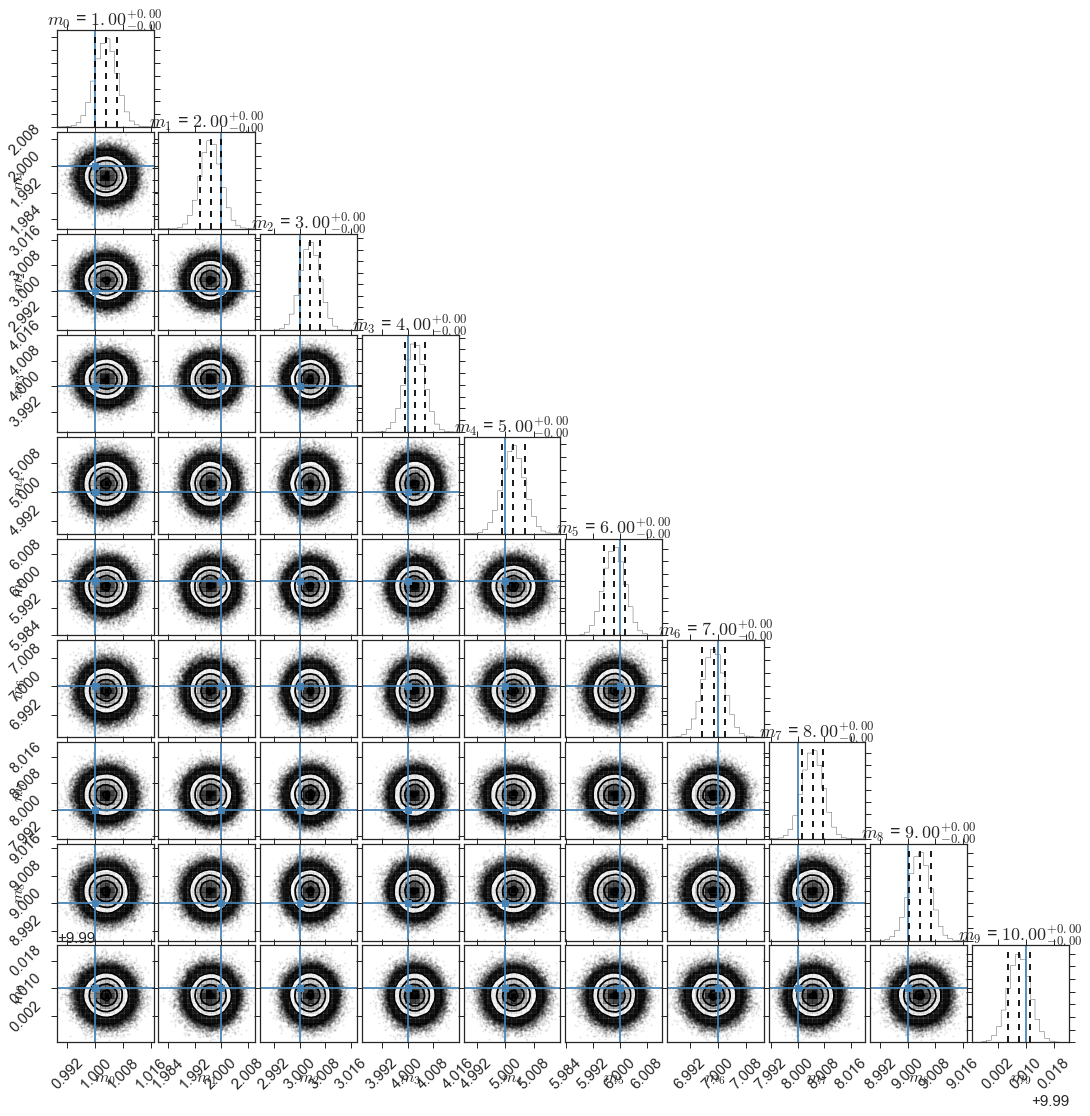

In [34]:
#
gdstans=samples2gdist(alan_stan_chain['samples'],alan_stan_chain['lnprob'],
                     trueval=dmv.mean,px='m')
gdstans.corner()

dictionary of samples and loglike array passed
chain array dimensions: 200000 x 10 =
time profiling scikit knn ..
(iter,mean,min,max) of LogLikelihood:  0 43.4231889235 29.5035782683 47.4436337019
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 5.59541503621 5.24469216192e-22 0.00139850413302 1.39850413302
1274 4 5.39316218534 4.11434245893e-22 0.00105810519626 1.34802602004
1623 4 5.1133516694 3.2056554614e-22 0.000787517583459 1.27814103795
2069 4 4.9228406238 2.40749203779e-22 0.000594761462341 1.23056146558
2636 4 4.76501942741 1.78804669588e-22 0.000451874767891 1.19114188816
3359 4 4.69499737248 1.41800529197e-22 0.000349408154535 1.17366199108
4281 4 4.63305485782 1.09673409211e-22 0.000270543349362 1.15819607862
5455 4 4.60252729041 8.59057182893e-23 0.000210921923395 1.15057909212
6951 4 4.52901320306 6.41756137781e-23 0.000162884848159 1.13221257955
8858 4 4.48631352534 5.10392408604e-23 0.000126613990499 1.121

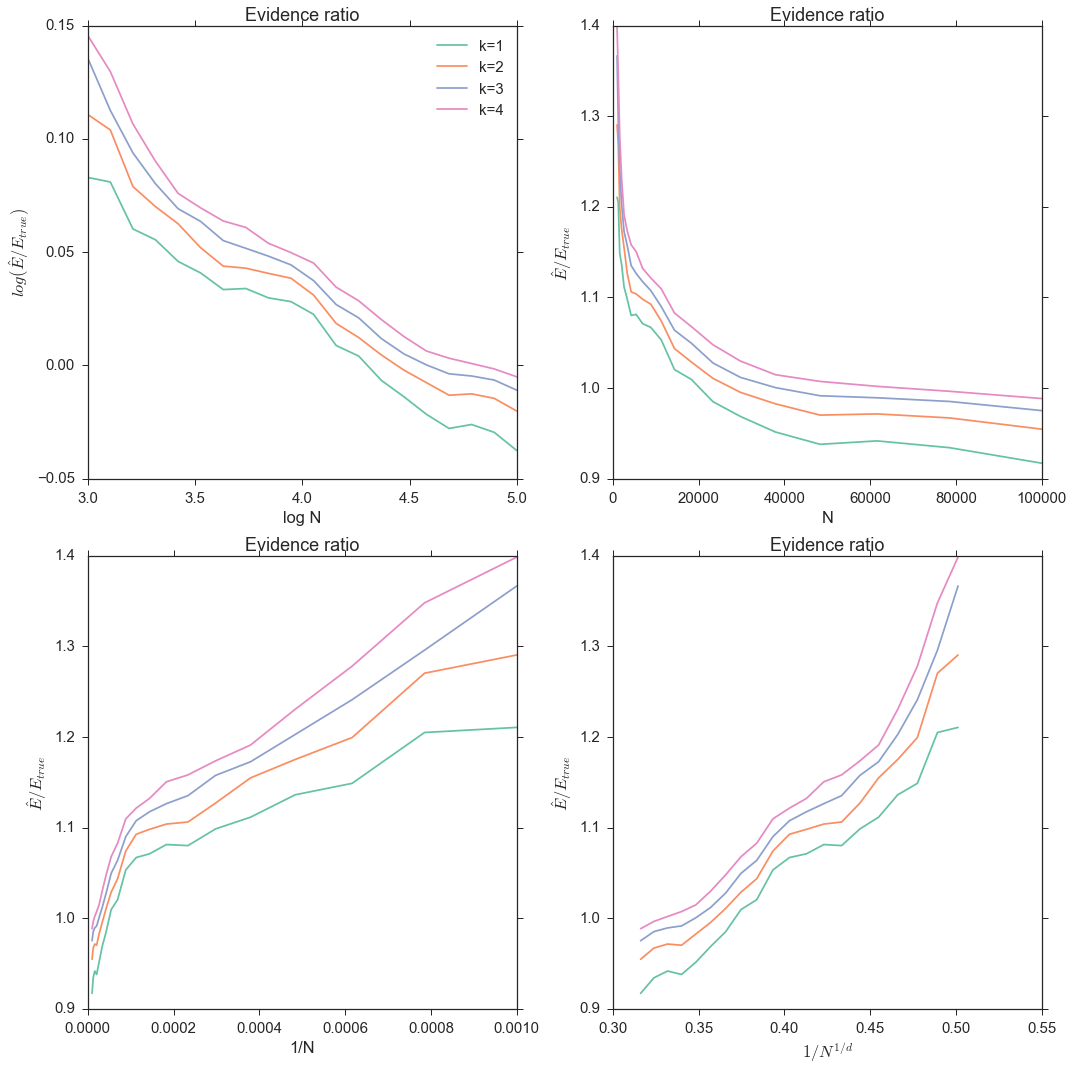

In [7]:
# Here given pystan samples and log probability, we compute evidence ratio 
ealan=eknn.echain(method=alan_stan_chain,verbose=2,ischain=True,brange=[3,5])
MLE,ptime=ealan.chains2evidence(rand=True,profile=True) 
ealan.vis_mle(MLE)

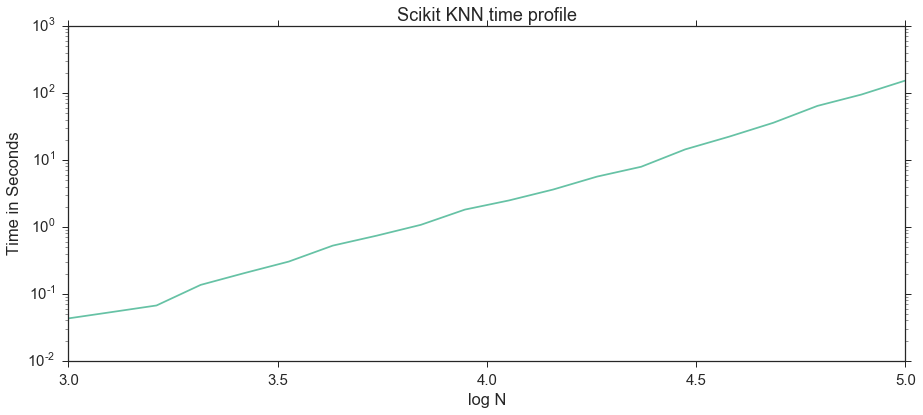

In [11]:
# plot KNN timing profile
fig,ax=plt.subplots(figsize=(15,6))
plt.semilogy(np.log10(ptime[:,0]),ptime[:,1])
plt.xlabel('log N')
plt.ylabel('Time in Seconds')
plt.title('Scikit KNN time profile')
#plt.legend(['k=%s'%k for k in range(1,kmax+1)])

### Pystan harry example 

In [21]:
import bayesglm as sglm
import pystan

harry_stanmodel='''
 data {
         int<lower=1> K;
         int<lower=0> N;
         real y[N];
         matrix[N,K] x;
 }
 parameters {
         vector[K] beta;
         real sigma;
 }
 model {         
         real mu[N];
         vector[N] eta   ;
         eta <- x*beta;
         for (i in 1:N) {
            mu[i] <- (eta[i]);
         };
         increment_log_prob(normal_log(y,mu,sigma));

 }
 '''   
harry=eknn.harry_eg()
df=pd.DataFrame()
df['x1']=harry.x
df['x2']=harry.x**2
df['y']=harry.y_sample

harry_data={'N':harry.ndata,
           'K':harry.ndim,
            'x':df[['x1','x2']],
           'y':harry.y_sample}
# Intialize pystan -- this will convert our pystan code into C++
# and run MCMC
#harry_fit = pystan.stan(model_code=harry_stanmodel, data=harry_data,
#                  iter=1000, chains=4)

In [23]:
iterations=10000
class jeffry_prior():
    def __init__(self, sigma):
        self.sigma = sigma

    def __repr__(self):
        return self.to_string()

    def to_string(self):
        return "normal(0,{0})".format(self.sigma)
class normal_prior():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __repr__(self):
        return self.to_string()

    def to_string(self):
        return "normal({0},{1})".format(self.mu, self.sigma)


#priors=(((i+1,), jeffry_prior(np.sqrt(harry.ndata))) for i in range(harry.ndim-1) )

priors={"x%s"%(i+1) : normal_prior(harry.theta[i+1],0.2) for i in range(harry.ndim-1) }

cache_fn='chains/harry_pystan_chain.pkl'
#read chain from cache if possible 
try:
    raise
    print('reading chain from: '+cache_fn)
    harry_stan_chain = pickle.load(open(cache_fn, 'rb'))
except:
    harry_fit = sglm.stan_glm("y ~ x1 + x2", df, 
                              family=sglm.family.gaussian(), 
                              iterations=iterations) #,priors=priors

    # Extract PyStan chain for Harry's GLM example
    harry_stan_chain=harry_fit.extract(permuted=True)   
    print('writing chain in: '+cache_fn)
    with open(cache_fn, 'wb') as f:
            pickle.dump(harry_stan_chain, f)

    #print stan model
    harry_model=harry_fit.stanmodel.model_code.expandtabs() #.rsplit('\n') 
    with open('harry.stan', 'w') as f:   
        f.write(harry_model[:])

theta_means = harry_stan_chain['beta'].mean(axis=0)
print('estimated: ',theta_means)
print('input: ',harry.theta)

#np.testing.assert_allclose(theta_means, harry.theta, atol=.01)

Using cached StanModel
writing chain in: chains/harry_pystan_chain.pkl
estimated:  [ 1.0427112   3.94138751 -0.99177162]
input:  [ 1.  4. -1.]


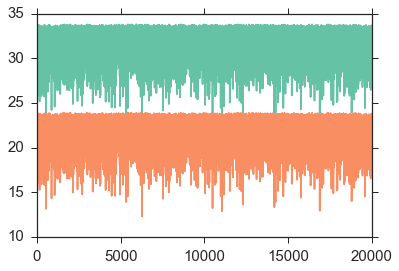

In [27]:
plt.plot(harry_stan_chain['lnprob'])
harry_stan_chain['lnprob']=harry_stan_chain['lnprob']+2*np.log(0.1/np.sqrt(1.0*harry.ndata))
plt.plot(harry_stan_chain['lnprob'])

(20000, 3)


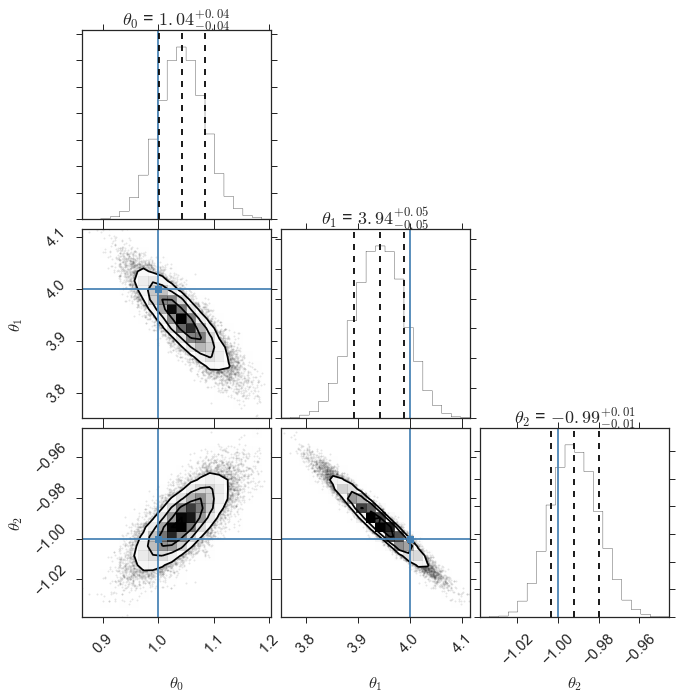

In [24]:
# Check input parameter recovery and estimate evidence
if 'beta' in harry_stan_chain.keys(): harry_stan_chain['samples']=harry_stan_chain.pop('beta')
if 'lp__' in harry_stan_chain.keys(): harry_stan_chain['lnprob']=harry_stan_chain.pop('lp__')
print(harry_stan_chain['samples'].shape)

#
gdstans=samples2gdist(harry_stan_chain['samples'],harry_stan_chain['lnprob'],
                     trueval=harry.theta,px='\\theta')
gdstans.corner(figsize=(10,10))
#gdstans.labels

In [28]:
# Here given pystan samples and log probability, we compute evidence ratio 
eharry=eknn.echain(method=harry_stan_chain,verbose=2,ischain=True)
MLE=eharry.chains2evidence() 
eharry.vis_mle(MLE)

dictionary of samples and loglike array passed
chain array dimensions: 20000 x 3 =
(iter,mean,min,max) of LogLikelihood:  0 21.7795918957 13.1354945511 23.8393857124
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 2313703.86867 4.03299512885e-07 578.281396819 578281.396819
1199 4 2188990.53546 3.18707485359e-07 456.324897949 547133.552641
1438 4 2128588.24933 2.65710540302e-07 369.996219248 532054.563279
1725 4 2051538.92969 2.06825543481e-07 297.281398304 512810.412074
2069 4 2017766.75141 1.70963012569e-07 243.779962717 504380.742862
2481 4 1930190.79044 1.37782624876e-07 194.477661505 482499.078194
2976 4 1851744.0848 1.10709972701e-07 155.543392255 462897.135352
3569 4 1807533.79888 9.10439370122e-08 126.604594724 451851.79857
4281 4 1759897.70931 7.3845311167e-08 102.767749449 439948.735389
5134 4 1729514.61843 5.98791494447e-08 84.2145697244 432357.600965
6158 4 1703398.27556 5.03960957222e-08 69.1510687111 425832.

IndexError: index 20000 is out of bounds for axis 0 with size 20000

## Emcee example

In [164]:
##learn about emcee sampler using help
#help(mec2d.sampler)

## emcee sampling using N-dimensional Gaussian likelihood

In [210]:
#
#gd_mc.samples.getName()

In [21]:
#Evidence calculation based on emcee sampling
mNd=eknn.alan_eg()
mecNd=make_emcee_chain(mNd,nwalkers=300)
samples,lnp=mecNd.mcmc(nmcmc=50000,thin=50)


mean_sample= [ 1.00061088  2.00334149  3.00123871  3.99596245  5.00167972  5.99809659
  6.99705564  7.99824596  9.00018827  9.99758212]
std_sample= [ 1.00055574  0.99746383  1.00035048  1.00423091  0.99743515  1.00117224
  1.00337876  1.00402215  1.0031026   1.00289956]

instance of a model class is passed
emcee total time spent:  356.074164867
samples shape:  (390000, 10)


In [26]:
#corner plot can be done also using getdist wrapper
#getdist wrapper has a lot more functionality than just plotting
gd_mc=samples2gdist(samples,lnp,trueval=mNd.mean,px='m')
print('correlation length:',gd_mc.samples.getCorrelationLength(3))
gd_mc.samples.thin(20)
##gd_mc.corner()
#mecNd.emcee_sampler.get_autocorr_time(fast=True)

correlation length: 19.928541271


In [28]:
thin_samples=gd_mc.samples.samples
thin_lnp=gd_mc.samples.loglikes

print(len(thin_lnp),thin_samples.shape)

#estimate evidence
ealan=eknn.echain(method={'samples':thin_samples,'lnprob':thin_lnp},
                  verbose=2,ischain=True,brange=[3,4.2])
MLE=ealan.chains2evidence(rand=True) 

19501 (19501, 10)
dictionary of samples and loglike array passed
chain array dimensions: 19501 x 10 =
(iter,mean,min,max) of LogLikelihood:  0 43.1259315307 -73.908750589 47.3198384749
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 5.2424274117 5.14634983388e-22 0.0013102792831 1.3102792831
1156 4 5.26151754956 4.54937945169e-22 0.00113762541612 1.31509498104
1337 4 5.18300758851 3.93643147911e-22 0.000968967580577 1.29550965523
1546 4 5.06254785189 3.31140450226e-22 0.000818520267081 1.26543233291
1789 4 4.94622530723 2.63629031927e-22 0.000691103158759 1.23638355102
2069 4 4.93346391663 2.41984441329e-22 0.000596044933747 1.23321696792
2393 4 4.92060159512 2.06001564386e-22 0.000514008314543 1.2300218967
2767 4 4.89297784968 1.73841273922e-22 0.000442043350771 1.22313395158
3200 4 4.80832934214 1.46912073305e-22 0.000375621384434 1.20198843019
3701 4 4.73061138551 1.25178698333e-22 0.000319527955792 1.18257296439
4281

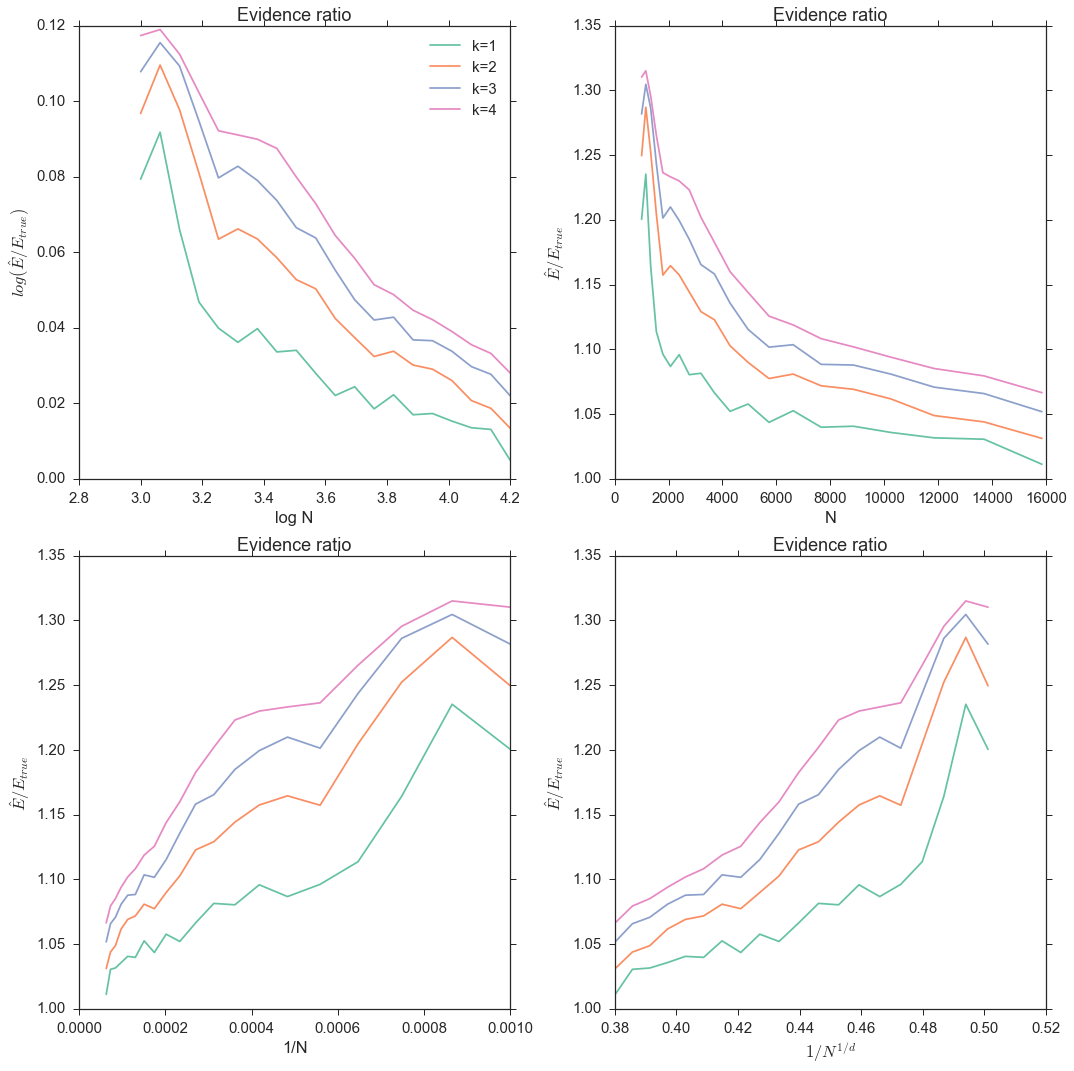

In [29]:
ealan.vis_mle(MLE)

## Emcee 2D example

In [ ]:
#test model class .. visualise uniform sampling
m2d=eknn.model_2d()

#test emcee wrapper 
mec2d=make_emcee_chain(m2d,nwalkers=200)
chain2d,fs=mec2d.mcmc(nmcmc=500)


#let's trangle plot chain samples 
fig = corner.corner(chain2d, labels=["$m$", "$b$"], extents=[[-1.1, -0.8], [3.5, 5.]],
                      truths=m2d.p, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(10,10)

# Plot back the results in the space of data
#fig = plt.figure()
#xl = np.array([0, 10])
#for m, b in chain2d[np.random.randint(len(chain2d), size=100)]:
#    if m<0:
#        plt.plot(xl, m*xl+b, color="k", alpha=0.1)
    
#plt.plot(xl, m2d.p[0]*xl+m2d.p[1], color="r", lw=2, alpha=0.8)
#plt.errorbar(m2d.x, m2d.y, yerr=m2d.yerr, fmt=".k")
#plt.title('Input Data vs Samples (grey)')
#fig.set_size_inches(12, 8)